In [1056]:
# загружаем необходимые библиотеки для получения данных
import requests
import os
import csv
import json
from pprint import pprint
from time import sleep

In [1057]:
# устанавливаем необходимые константы
# CSV - это путь и собственно сам файл для сохранения его в формате CSV
# URL - адрес к вакансиям на hh
# HEADERS - отправляем заголовок для того, чтобы не было проблем с ответом
CSV = 'data.csv'
URL = 'https://api.hh.ru/vacancies'
HEADERS = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.1 Safari/605.1.15'
}

In [1058]:
# функция для получения одной страницы URL
# так же мы получаем ответ от сервера, если 200 идем дальше, все хорошо
def get_page (url, params = ''):
    req = requests.get(url, headers=HEADERS, params=params)
    return req

In [1059]:
# функция для получения контента одной страницы
# ответ получаем в формате json
# проходимся циклом по ответу json, а именно по ключу items
# необходимые данные (в формате словаря) добавляем в список 
def get_content(req=get_page(URL)):
    tmp = req.json()
    data = []
    for item in tmp['items']:
        data.append({
            'city':item['area']['name'],
            'company':item['employer']['name'],
            'vacancy':item['name'],
            'salary':item['salary'],
            'schedule':item['schedule']['name'],
            'requirement':item['snippet']['requirement'],
            'responsibility':item['snippet']['responsibility']
            })
    return data

In [1060]:
# функция для сохранения данных в формате csv
def save_to_csv(items, path):
    with open (path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['city','company','vacancy','sale','shedule','requirement','responsibility'])
        for item in items:
            writer.writerow([item['city'],item['company'],item['vacancy'],item['salary'],item['schedule'],item['requirement'],item['responsibility']]) 

In [1061]:
# сам парсер для получения необходимых данных и дальнейшего их сохранения в файл формата csv
# к сожалению API HH позволяет получить только 2000 записей
def parser():
    job_titles = ['Data Scientist', 'Data Analytics', 'Аналитик данных']
    for job in job_titles:
        result = get_page(URL)
        data = []
        if result.status_code == 200:
            for page in range(0, 20):
                try:
                    result = get_page(URL, params={'text': job,'area':'113', 'per_page':'100','page':page})
                    data.extend(get_content(result))
                    save_to_csv(data, CSV)
                except:
                    sleep(.25)
        
parser()

### А вот с этого момента начинаем анализ...

Данные выгружены на момент декабря 2020 г., изучим данные, обработаем их и посмотрим:
- по регионам + выделим топ 10 городов:
    - медианную зарплату;
    - количество рабочих мест в зависимости от графика работы (Удаленная работа, Полный день и т.п.)
    - какие требования предъявляют работодатели в зависимости от профессии;
    - какие задачи необходимо решать на рабочем месте.

In [1062]:
# загрузим необходимые библиотеки для анализа данных
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1063]:
df = pd.read_csv('data.csv')
df.head()

,city,company,vacancy,sale,shedule,requirement,responsibility
0,Москва,МВС ГРУП,Ведущий аналитик данных/Руководитель группы,"{'from': 230000, 'to': None, 'currency': 'RUR'...",Полный день,Базовые навыки финансового моделирования. Умен...,Анализ имеющихся <highlighttext>данных</highli...
1,Санкт-Петербург,Медицинские Скрининг Системы,Аналитик по медицинским данным (junior),"{'from': 60000, 'to': 120000, 'currency': 'RUR...",Полный день,"Знания в области биологии и/или медицины, дост...",Маммография - детектирование злокачественных и...
2,Москва,Bip.ru,Data analyst / Продуктовый аналитик,"{'from': 200000, 'to': None, 'currency': 'RUR'...",Полный день,Что мы хотим увидеть у вас: ● Опыт работы <hig...,Создание систем доступа <highlighttext>данных<...
3,Москва,ДомКлик,Аналитик данных,NaN,Полный день,Хорошо знаете математику и владеете основами с...,Построение аналитической отчетности в Excel и ...
4,Санкт-Петербург,КОЛХОЗ,Аналитик,"{'from': 100000, 'to': None, 'currency': 'RUR'...",Полный день,Опыт работы в торговых компаниях как преимущес...,<highlighttext>Аналитика</highlighttext> прода...


In [1064]:
# посмотрим на содержимое датафрейма
# может будет сразу видно какие-нибудь аномалии
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            2000 non-null   object
 1   company         2000 non-null   object
 2   vacancy         2000 non-null   object
 3   sale            530 non-null    object
 4   shedule         2000 non-null   object
 5   requirement     1994 non-null   object
 6   responsibility  1989 non-null   object
dtypes: object(7)
memory usage: 109.5+ KB


In [1065]:
# преобразуем столец sale к числовому формату
# так как данны представлены в формате object
# то с использованием аноноимной функции разделим данные по ','
# и у первого элемента вырежим необходимое количество знаков
# далее преобразуем все к числовому формату, пропущенные значения заменим на 0
sales = df.sale.apply(lambda x: str(x).split(',')[0][9:])
df['sale'] = sales
df['sale'] = pd.to_numeric(df['sale'].str.replace('\D', ''), errors='ignore')
df.sale.fillna(0, inplace=True)

In [1066]:
df.head()

,city,company,vacancy,sale,shedule,requirement,responsibility
0,Москва,МВС ГРУП,Ведущий аналитик данных/Руководитель группы,230000.0,Полный день,Базовые навыки финансового моделирования. Умен...,Анализ имеющихся <highlighttext>данных</highli...
1,Санкт-Петербург,Медицинские Скрининг Системы,Аналитик по медицинским данным (junior),60000.0,Полный день,"Знания в области биологии и/или медицины, дост...",Маммография - детектирование злокачественных и...
2,Москва,Bip.ru,Data analyst / Продуктовый аналитик,200000.0,Полный день,Что мы хотим увидеть у вас: ● Опыт работы <hig...,Создание систем доступа <highlighttext>данных<...
3,Москва,ДомКлик,Аналитик данных,0.0,Полный день,Хорошо знаете математику и владеете основами с...,Построение аналитической отчетности в Excel и ...
4,Санкт-Петербург,КОЛХОЗ,Аналитик,100000.0,Полный день,Опыт работы в торговых компаниях как преимущес...,<highlighttext>Аналитика</highlighttext> прода...


In [1067]:
def region(row):
    if row['city'] == 'Москва':
        return 'Москва'
    elif row['city'] == 'Санкт-Петербург':
        return 'Санкт - Петербург'
    else:
        return 'Регионы'

In [1068]:
df['region'] = df.apply(region, axis=1)

In [1069]:
sale_is_0 = df[df.sale==0]

In [1070]:
# в зарплатных предлоржениях получилось, 
# что 77% вакансий не указывают зарплатные предложения
df.isin(sale_is_0).sum()[0]/df.shape[0]*100

76.85

In [1071]:
# для получения зарплатных предложений по регионам
# оставим 30% значений
sale_not_0 = df = df.drop(np.where(df['sale'] == 0)[0])
sale_not_0

,city,company,vacancy,sale,shedule,requirement,responsibility,region
0,Москва,МВС ГРУП,Ведущий аналитик данных/Руководитель группы,230000.0,Полный день,Базовые навыки финансового моделирования. Умен...,Анализ имеющихся <highlighttext>данных</highli...,Москва
1,Санкт-Петербург,Медицинские Скрининг Системы,Аналитик по медицинским данным (junior),60000.0,Полный день,"Знания в области биологии и/или медицины, дост...",Маммография - детектирование злокачественных и...,Санкт - Петербург
2,Москва,Bip.ru,Data analyst / Продуктовый аналитик,200000.0,Полный день,Что мы хотим увидеть у вас: ● Опыт работы <hig...,Создание систем доступа <highlighttext>данных<...,Москва
4,Санкт-Петербург,КОЛХОЗ,Аналитик,100000.0,Полный день,Опыт работы в торговых компаниях как преимущес...,<highlighttext>Аналитика</highlighttext> прода...,Санкт - Петербург
5,Москва,"Эверис, Представительство",Data Analyst,150000.0,Полный день,"...<highlighttext>данных</highlighttext>, в т....","Поиск, формулировка и проверка гипотез самосто...",Москва
...,...,...,...,...,...,...,...,...
1983,Москва,Адресник,Аналитик продаж,70000.0,Полный день,...работы с базами <highlighttext>данных</high...,Подготовка технических заданий по автоматизаци...,Москва
1986,Благовещенск (Амурская область),Сталепромышленная компания,Аналитик,45000.0,Полный день,Активная жизненная позиция. -Высшее образовани...,Участие в ценообразовании ( анализ конкурентов...,Регионы
1994,Березники,Diamond Personnel R&C,HR аналитик,80000.0,Полный день,Успешно реализованные проекты по внедрению HR ...,Работа с большими массивами <highlighttext>дан...,Регионы
1995,Муром,Муромский стрелочный завод,Консультант-аналитик АСУП,40000.0,Полный день,Опыт работы в техподдержке АСУП (либо в сфере ...,Поддержка пользователей АСУП (TechnologiCS). А...,Регионы


In [1072]:
median_sale = sale_not_0.groupby('region') \
          .agg({'sale':pd.Series.median})

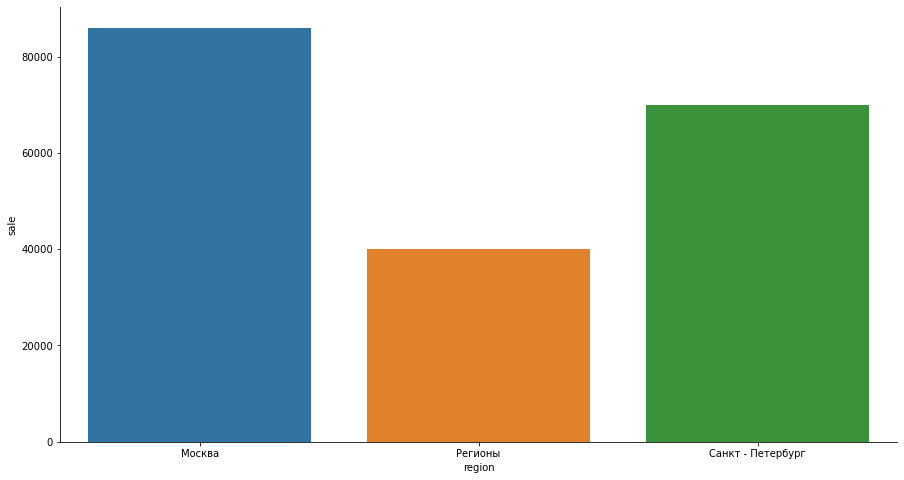

In [1073]:
plt.figure(figsize=(15, 8))
sns.barplot(median_sale.index, median_sale.sale)
sns.despine()
plt.show()

In [1074]:
median_sale_top_city = sale_not_0.groupby('city') \
          .agg({'sale':pd.Series.median}) \
          .sort_values('sale', ascending=False) \
          .head(10)

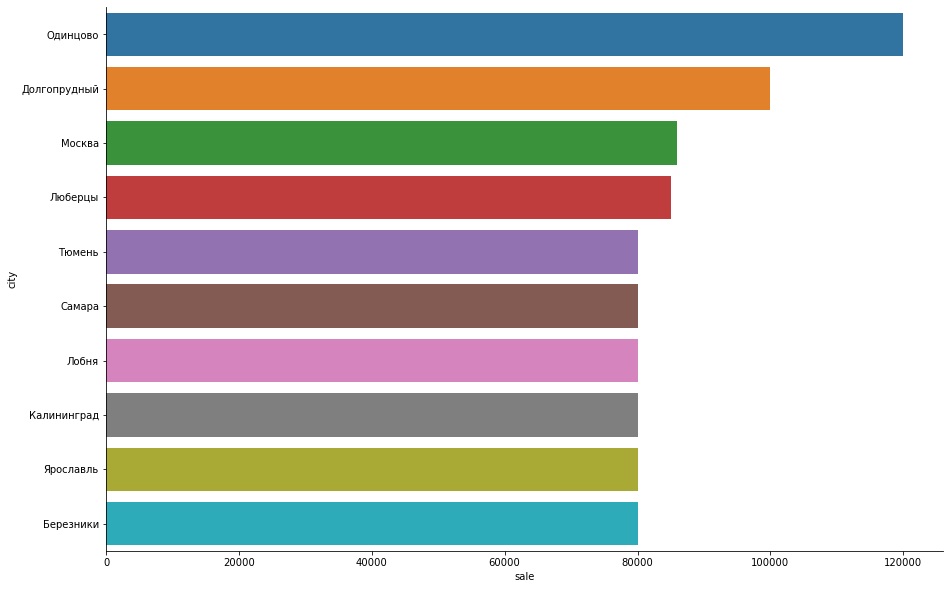

In [1075]:
plt.figure(figsize=(15, 10))
sns.barplot(median_sale_top_city.sale, median_sale_top_city.index, orient='h')
sns.despine()
plt.show()

In [1076]:
sale_not_0.groupby(['city', 'vacancy'], as_index=False) \
        .agg({'sale':'max'}) \
        .sort_values('sale', ascending=False).head(10)

,city,vacancy,sale
185,Москва,Руководитель направления дата аналитики/data s...,260000.0
159,Москва,Ведущий аналитик данных/Руководитель группы,230000.0
290,Санкт-Петербург,Ведущий продуктовый аналитик,200000.0
173,Москва,Менеджер платформы клиентских данных и аналити...,200000.0
160,Москва,Ведущий продуктовый аналитик,200000.0
100,Москва,Data analyst / Продуктовый аналитик,200000.0
136,Москва,Аналитик данных/Онтолог,180000.0
179,Москва,Продуктовый аналитик,180000.0
153,Москва,Бизнес аналитик,180000.0
154,Москва,Бизнес-аналитик,180000.0


Вывод:
- наибольшее предложения относительно зарплаты предлагает в основном Москва (соотношение с Санкт - Петербургом - 1/10);
- Руководительнь направления дата - аналитики с зарплатой 260 тр

In [1077]:
sale_not_0.groupby(['city', 'vacancy'], as_index=False) \
        .agg({'sale':'max'}) \
        .sort_values('sale').head(10)

,city,vacancy,sale
152,Москва,Бизнес Аналитик/Аналитик по оптимизации бизнес...,400.0
309,Санкт-Петербург,Трейдер-аналитик,500.0
200,Москва,Трейдер-аналитик,500.0
105,Москва,Web - аналитик,800.0
142,Москва,Аналитик по маркетингу и Web,10000.0
59,Казань,Аналитик-исследователь (стажер),10000.0
44,Екатеринбург,Системный аналитик (Стажер),10000.0
113,Москва,Аналитик (количественные исследования),10000.0
195,Москва,Стажер-аналитик в сфере маркетинга,12000.0
62,Казань,Бизнес-аналитик (стажер),20000.0


Вывод:
- наиболее низкие показатели зарплаты у стажеров (в среднем это 10 тр в месяц)

In [1091]:
df.groupby(['shedule'], as_index=False) \
        .count() \
        .sort_values('sale').head(10)

,shedule,city,company,vacancy,sale,requirement,responsibility,region
2,Сменный график,2,2,2,2,2,2,2
0,Гибкий график,17,17,17,17,17,17,17
3,Удаленная работа,60,60,60,60,60,60,60
1,Полный день,384,384,384,384,384,381,384


Вывод:
- наиболее часто встречаемые типы объявлений: удаленная работа + полный день
- так как соотношение удаленной работы к полному дню работы значительно меньше, то все-таки чаще работадатели хотят видеть своих подчиненных рядом

In [1078]:
# проведем лемматизацию с использованием библиотеки Яндекса MyStem
# и с использованием библеотеки Counter посчитаем количество повторений слов
requirement = [str(req) for req in df['requirement'].unique()]
string = ', '.join(requirement)

In [1079]:
from pymystem3 import Mystem
m = Mystem()
lemmas = m.lemmatize(string)

In [1082]:
from collections import Counter
c = Counter()
for w in lemmas:
    c[w]+=1
c = dict(c)
sorted_by_value = sorted(c.items(), key=lambda kv: kv[1], reverse=True)
sorted_by_value

[(' ', 4931),
 ('highlighttext', 788),
 (', ', 783),
 ('. ', 747),
 ('>', 550),
 ('</', 394),
 (' <', 337),
 ('опыт', 335),
 ('работа', 294),
 ('...', 262),
 ('и', 262),
 ('.', 245),
 ('данные', 233),
 ('знание', 220),
 ('в', 217),
 ('с', 178),
 (' (', 167),
 ('аналитик', 142),
 ('> ', 126),
 (' , ', 124),
 ('умение', 122),
 ('высокий', 120),
 (')', 119),
 ('Excel', 115),
 ('образование', 115),
 ('на', 98),
 ('большой', 92),
 ('-', 90),
 ('год', 80),
 ('от', 69),
 ('SQL', 69),
 ('пользователь', 64),
 ('анализ', 64),
 ('аналитический', 64),
 ('навык', 63),
 (': ', 62),
 ('/', 60),
 ('уровень', 59),
 ('владение', 56),
 ('MS', 55),
 ('или', 52),
 ('объем', 52),
 ('>, ', 51),
 ('работать', 50),
 ('таблица', 49),
 ('понимание', 47),
 ('массив', 45),
 ('уверенный', 45),
 ('1С', 43),
 ('технический', 41),
 ('бизнес', 40),
 ('сводный', 38),
 ('система', 37),
 ('экономический', 36),
 ('база', 35),
 (' - ', 35),
 ('продвинутый', 34),
 ('быть', 33),
 ('способность', 33),
 ('склад', 32),
 ('по', 3

Наиболее часто встречаемые требования (по убыванию частоты слов в датафрейме):
- Опыт работы аналитиком
- Excel
- SQL
- Понимание бизнес процессов
- 1C
- Power BI
- Python

In [1086]:
responsibility = [str(req) for req in df['responsibility'].unique()]
resp_string = ', '.join(responsibility)

In [1088]:
from pymystem3 import Mystem
m = Mystem()
resp_lemmas = m.lemmatize(resp_string)

In [1089]:
from collections import Counter
c = Counter()
for w in resp_lemmas:
    c[w]+=1
c = dict(c)
resp_sorted_by_value = sorted(c.items(), key=lambda kv: kv[1], reverse=True)
resp_sorted_by_value

[(' ', 5170),
 ('highlighttext', 920),
 (', ', 726),
 ('. ', 653),
 ('>', 596),
 ('и', 506),
 ('</', 460),
 (' <', 420),
 ('данные', 357),
 ('...', 260),
 ('.', 241),
 ('> ', 224),
 ('анализ', 223),
 ('в', 196),
 ('по', 173),
 ('с', 119),
 (' , ', 109),
 ('разработка', 97),
 ('для', 93),
 ('-', 93),
 (' (', 93),
 ('отчет', 87),
 ('на', 86),
 ('аналитик', 86),
 ('сбор', 85),
 ('работа', 80),
 ('подготовка', 80),
 ('система', 77),
 ('процесс', 73),
 ('бизнес', 61),
 ('>, ', 60),
 ('формирование', 60),
 ('аналитический', 56),
 ('обработка', 55),
 ('отчетность', 54),
 (')', 54),
 ('информация', 49),
 ('продажа', 48),
 ('компания', 46),
 ('требование', 45),
 ('база', 44),
 ('показатель', 41),
 ('из', 41),
 ('участие', 38),
 ('задача', 36),
 ('расчет', 35),
 ('/', 35),
 ('клиент', 34),
 ('ведение', 33),
 ('решение', 32),
 ('проект', 31),
 ('проведение', 31),
 ('создание', 30),
 ('различный', 30),
 ('составление', 30),
 ('контроль', 30),
 ('исследование', 29),
 ('технический', 28),
 (' - ', 2

Наиболее часто встречаемые задачи (по убыванию частоты слов в датафрейме):
- Анализ данных
- Разработка отчетов
- Сбор и подготовка данных
- Формирование аналитической отчетности
- Работа с клиентами
- Мониторинг
- Автоматизация работы
- Изучение рынка и заказчика